# Metode Evaluasi Segmentasi

Di notebook ini dieksplor mengenai metode evaluasi hasil segmentasi dibandingkan dengan sebuah label ground truth. Adapun metode yang digunakan ada 2:

1. IoU / Jaccard Index

<img src="https://render.githubusercontent.com/render/math?math=IoU = \frac{TP}{TP + FP + FN}">

Atau bisa juga diformulasikan sebagai

<img src="https://render.githubusercontent.com/render/math?math=IoU = \frac{\mid Pred \cap GT\mid}{\mid Pred \cup GT\mid}">

1. F1 Score / Dice Coefficient

<img src="https://render.githubusercontent.com/render/math?math=IoU = \frac{2 \times TP}{2 \times TP %2b FP %2b FN}">

Atau bisa juga diformulasikan sebagai

<img src="https://render.githubusercontent.com/render/math?math=IoU = \frac{2 \times \mid Pred \cap GT \mid}{\mid Pred\mid %2b \mid GT\mid}">

In [1]:
from segment import BiSeNet_keras, FaceParser
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def log_softmax(img):
    h,w,c = img.shape
    max_along_channels = img[:,:,np.arange(c)].max(axis=-1)
    max_along_channels = max_along_channels[...,None]
    normalized = img - max_along_channels
    assert normalized.shape == img.shape
    normalized = np.exp(normalized)
    sum_along_channels = normalized[:,:,np.arange(c)].sum(axis=-1)
    sum_along_channels = sum_along_channels[...,None]
    print(sum_along_channels.shape)
    return np.log(normalized / sum_along_channels)

In [3]:
def normalize_input(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        # x should be RGB with range [0, 255]
        return ((x / 255) - mean)  / std

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def show_threshold(img,threshold):
    im = img.copy()
    im = np.where(im > threshold,1,0)
    showimg(im)

In [6]:
def preprocess_label(lbl):
    label_out = np.zeros((512,512,19),dtype=np.uint8)
    label_out[lbl == 255] = 1
    return label_out

In [42]:
def pred_into_masks(img):
    result = np.zeros_like(img,dtype=np.uint8)
    max_idxs = img.argmax(axis=-1)
    m,n = img.shape[:2]
    I,J = np.ogrid[:m,:n]
    result[I,J,max_idxs] += 1
    return result

In [150]:
def dice(pred,gt):
    intersection = np.logical_and(pred,gt)
    pred_area = np.sum(pred,axis=(0,1))
    gt_area = np.sum(gt,axis=(0,1))
    intersection_sum = np.sum(intersection,axis=(0,1))
    totalarea = pred_area + gt_area
    indices = np.nonzero(totalarea)
    dice_score = np.zeros(19)
    dice_score[indices] += 2 * intersection_sum[indices] / totalarea[indices]
    return dice_score 

In [151]:
def IoU(pred,gt):
    union = np.logical_or(pred,gt)
    intersection = np.logical_and(pred,gt)
    union_sum = np.sum(union,axis=(0,1))
    intersection_sum = np.sum(intersection,axis=(0,1))
    indices = np.nonzero(union_sum)
    iou_score = np.zeros(19)
    iou_score[indices] += intersection_sum[indices] / union_sum[indices]
    return iou_score   

In [137]:
def resize(image,target_shape):
    wt,ht = target_shape
    h,w = image.shape[:2]
    interpolation = cv2.INTER_CUBIC
    if wt * ht < w * h:
        interpolation = cv2.INTER_AREA
    return cv2.resize(image,target_shape,interpolation=interpolation)

In [8]:
bisenet = BiSeNet_keras()

In [9]:
bisenet.load_weights('./bisenet/BiSeNet_keras.h5')

In [142]:
face_img = read_rgb('./samples/celebmasks/images/0.jpg')

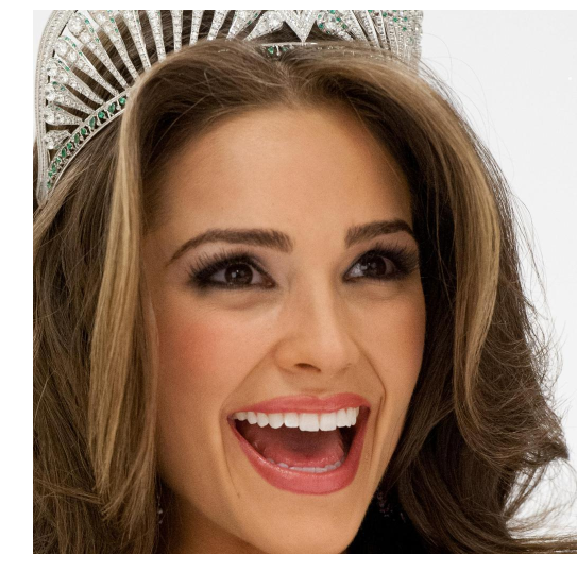

In [143]:
face_img = resize(face_img,(512,512))
showimg(face_img)

In [13]:
face_img = normalize_input(face_img)

In [14]:
face_img = face_img[None,...]

In [43]:
res = bisenet.predict(face_img)[0]

In [44]:
preds = pred_into_masks(res)

In [108]:
preds.shape

(512, 512, 19)

### Visualisasi hasil prediksi dapat dilakukan dengan mengambil argmax pada axis terakhir

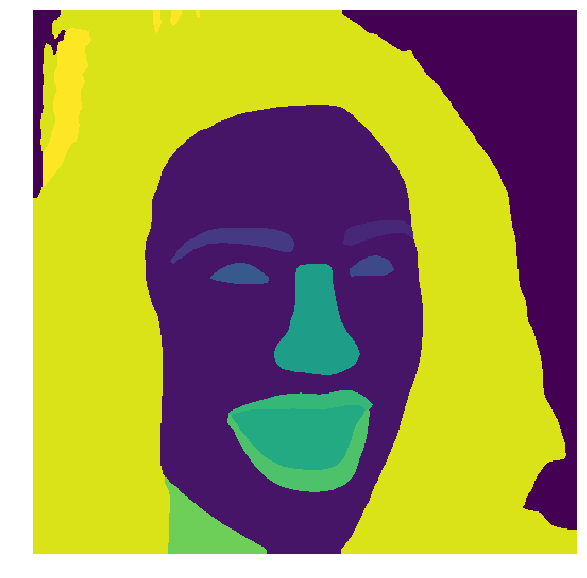

In [109]:
viz = preds.argmax(axis=-1)
showimg(viz)

## Ilustrasi hitungan : IoU

Misal kita ingin mengukur seberapa baik segmentasi wajah bila dibandingkan dengan ground truth

Berikut segmentasi wajah hasil prediksi :

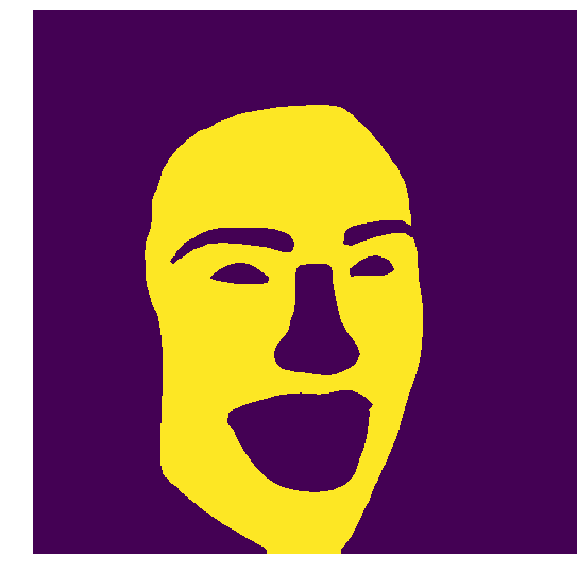

In [110]:
showimg(preds[:,:,1])

Dan segmentasi wajah dari ground truth :

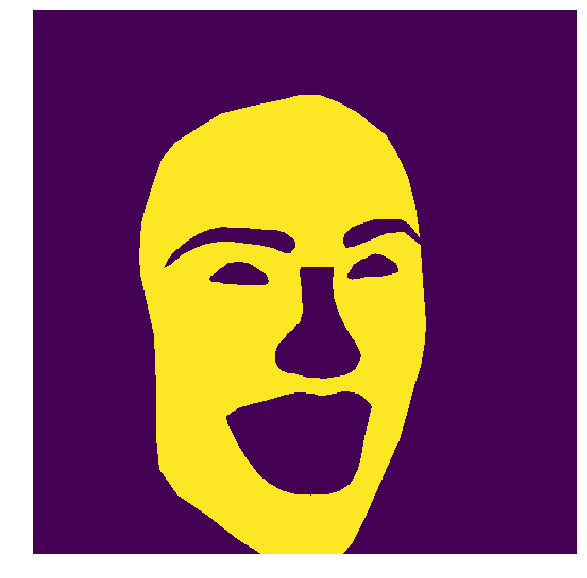

In [112]:
groundtruthmask = np.load('./samples/celebmasks/labels/0_label.npy')
showimg(groundtruthmask[:,:,1])

Sesuai definisi IoU, kita cari Interseksi dan Union dari prediksi dan label

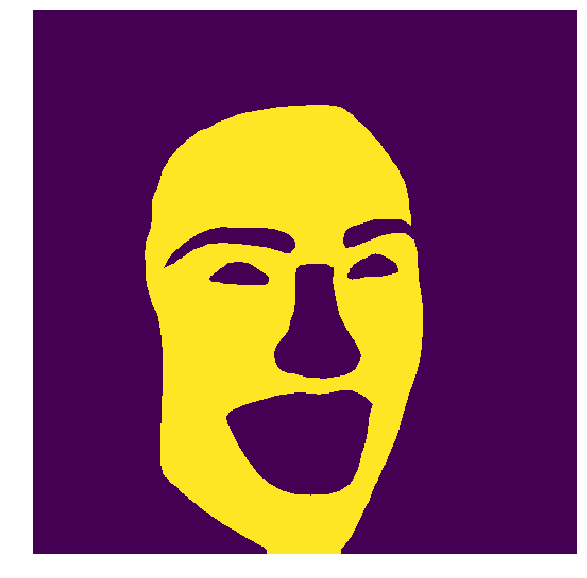

In [113]:
intersection = np.logical_and(preds,groundtruthmask)
showimg(intersection[:,:,1])

Kemudian kita cari union dari prediksi dan label

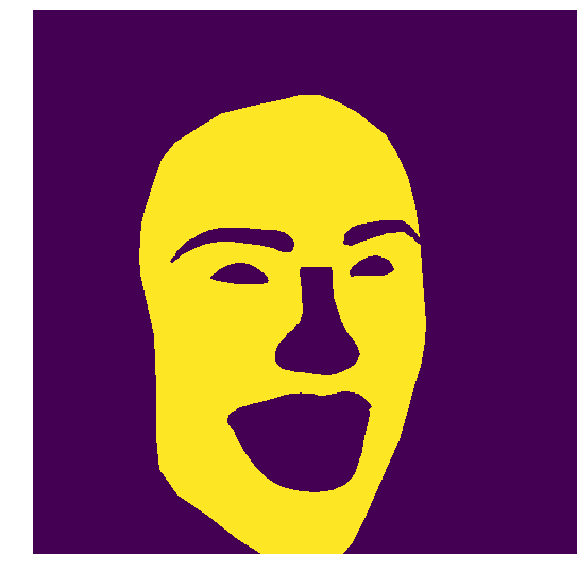

In [114]:
union = np.logical_or(preds,groundtruthmask)
showimg(union[:,:,1])

Kita hitung area dari keduanya (cukup menghitung jumlah pixel), lalu tinggal hitung rasio interseksi terhadap union

Perhatikan bahwa hanya diambil indeks dimana unionnya tidak nol (yang berarti kelasnya memang tidak ada).

Untuk mendapatkan average IoU untuk 1 gambar saja, cukup hitung average IoU semua kelas

In [119]:
intersection_area = np.sum(intersection,axis=(0,1))
union_area = np.sum(union,axis=(0,1))
indices = np.nonzero(union_area)
IoU = intersection_area[indices] / union_area[indices]
print(f"Average IoU : {IoU.mean()}")

Average IoU : 0.7689778538788841


## Ilustrasi hitungan : Dice Score

Untuk Dice Score, yang dicari adalah rasio dari interseksi x 2 terhadap total area dari kedua label.

In [125]:
area_gt = np.sum(groundtruthmask,axis=(0,1))
area_preds = np.sum(preds,axis=(0,1))
area_sum = area_gt + area_preds
indices = np.nonzero(area_sum)

In [126]:
dice = 2 * intersection_area[indices] / area_sum[indices]
print(f"Average dice : {dice.mean()}")

Average dice : 0.8379440030449706


## Penghitungan IoU dan Dice kumulatif

Penghitungan dilakukan secara satu per satu dikarenakan memory GPU yang tidak cukup untuk melakukan perhitungan untuk setiap batch.

Perhitungan IoU dan dice sudah dibungkus melalui fungsi dice() dan IoU()

In [153]:
from glob import glob
import os

In [154]:
images = glob('./samples/celebmasks/images/*.jpg')
label_dir = './samples/celebmasks/labels'

In [155]:
allIoU = np.zeros(19)
allDice = np.zeros(19)

In [156]:
def readPrepImage(path):
    img = read_rgb(image)
    img = resize(img,(512,512))
    img = normalize_input(img)
    img = img[None,...]
    return img

In [157]:
for image in images:
    number = os.path.basename(image).split(".")[0]
    label_file = f"{number}_label.npy"
    label_path = os.path.join(label_dir,label_file)
    label = np.load(label_path)
    img = readPrepImage(image)
    preds = bisenet.predict(img)[0]
    preds = pred_into_masks(preds)
    allIoU += IoU(preds,label)
    allDice += dice(preds,label)

Setelah mendapatkan nilai IoU dan Dice, perama dihitung dulu rerata tiap kelas, baru rerata secara umum

In [158]:
allIoU /= len(images)
allDice /= len(images)

In [159]:
print(f"IoU Score : {allIoU.mean()}")
print(f"Dice Score : {allDice.mean()}")

IoU Score : 0.533143112499541
Dice Score : 0.5868495347594076
